# Visual Plant Recognition

This Jupyter Notebook uses a pre-trained Inception v3 architecture to train on the [Oxford 102 dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/). The dataset consists of 102 different plants. PyTorch is used as a framework.

## Dataset Loading

Importing all the necessary frameworks, libraries and classes

In [1]:
from pathlib import Path
from matplotlib import pyplot as plt
from torchvision import transforms, utils, datasets
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.model_selection import KFold
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from helper import convert_mat_to_csv, progress_bar
from dataset_loader import Oxford102Dataset, Rescale, RandomCrop, ToTensor, Normalize
from visualization import image_visualization, batch_visualization
from model import SimpleNet
from training import train_epoch

Converting the MatLab files with the labels into a csv

In [2]:
path_dataset = Path("../dataset/")
if not(path_dataset.joinpath("imagelabels.csv").exists()):
    convert_mat_to_csv(path_dataset.joinpath("imagelabels.mat"))
    print("Created image labels")
else: 
    print("Image labels already exist as csv")
if not(path_dataset.joinpath("setid.csv").exists()):    
    convert_mat_to_csv(path_dataset.joinpath("setid.mat"))
    print("Created set id")
else: 
    print("Set id already exist as csv")

Image labels already exist as csv
Set id already exist as csv


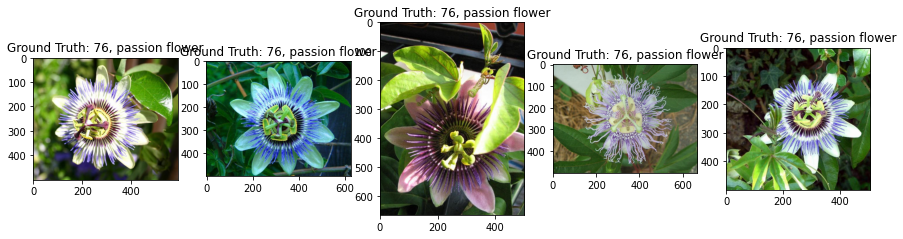

In [3]:
oxford102Dataset = Oxford102Dataset(csv_file='../dataset/imagelabels.csv',
                                    dataset_dir='../dataset/')

batch_visualization(oxford102Dataset, (1, 5), (15, 4))
    


<Figure size 432x288 with 0 Axes>

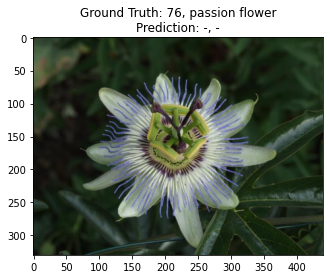

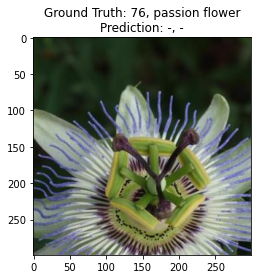

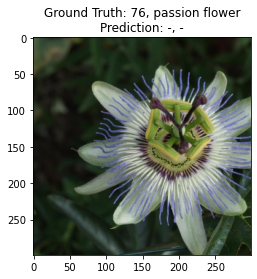

In [4]:
scale = Rescale(330)
crop = RandomCrop(299)
composed = transforms.Compose([Rescale(330),
                               RandomCrop(299)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = oxford102Dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)
    image_visualization(transformed_sample['image'], sample['plant_label'])


plt.show()

Putting everything together and iterating trough the dataset with dataloader

Loading the Oxford 102 Dataset with a custome dataloader and visualise it

In [5]:
transformed_dataset = Oxford102Dataset(csv_file='../dataset/imagelabels.csv',
                                    dataset_dir='../dataset/', transform=transforms.Compose([
        RandomCrop(224),
        ToTensor(),
        Normalize()]))

train_len = int(0.8 * len(transformed_dataset))
train_data, test_data = random_split(transformed_dataset, [train_len, 
                                                           len(transformed_dataset)-train_len], 
                                                             generator=torch.Generator().manual_seed(1))
train_dataloader = DataLoader(train_data, batch_size=32,
                        shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_data, batch_size=32,
                        shuffle=True, num_workers=4)

## Training

In [6]:
# instanciate model
model = SimpleNet()

# move tensors to GPU if CUDA is available
use_cuda = torch.cuda.is_available()
if use_cuda:
    model_scratch.cuda()
    
# loss function
loss_function = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=5e-6)

In [7]:
def init_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight.data)

In [10]:
def train(n_epochs, train_dataset, model, optimizer, loss_function, use_cuda, batch_size=32, k_splits = 5):
    p_bar = progress_bar(int(len(train_dataset) * (k_splits - 1) / (k_splits * batch_size)))
    p_bar['progress'].initialize()
    kfold = KFold(n_splits=k_splits, shuffle=True, random_state=1)
    for fold, (train_idx, test_idx) in enumerate(kfold.split(np.arange(len(train_dataset)))):
        p_bar['split'](fold + 1)
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
        test_subsampler = torch.utils.data.SubsetRandomSampler(test_idx)

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_subsampler)
        valid_dataloader = DataLoader(train_dataset, batch_size=batch_size, sampler=test_subsampler)
        
        model.apply(init_weights)

        for epoch in range(1, n_epochs+1):
            p_bar['epoch'](epoch)
            train_epoch(model, train_dataloader, optimizer, loss_function, use_cuda, p_bar)

            p_bar['progress'].set_cursor_position()

    return model


In [11]:
# train the model
model_scratch = train(1, train_data, model, optimizer, 
                      loss_function, use_cuda, k_splits=3)

/var/folders/8g/5m7lsl2s5rgdbnq1_34nrfg40000gn/T/ipykernel_85561/975651842.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight.data)


Split: 1 Epoch: 1 [>                        ] 137/136  409s/epoch - Loss: 0 - Acc: 0 
Split: 2 Epoch: 1 [>                        ] 137/136  407s/epoch - Loss: 0 - Acc: 0 
Split: 3 Epoch: 1 [====>                    ] 22/136  65s/epoch - Loss: 0 - Acc: 0 

KeyboardInterrupt: 